In [ ]:
!pip install qiskit
!pip install qiskit-machine-learning
!pip install pylatexenc
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 18.2 s (started: 2023-04-27 17:01:48 +00:00)


In [ ]:
# VQC on Iris dataset in qiskit, based on: https://qiskit.org/ecosystem/machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html

# prepare Iris dataset
import numpy as np;
from sklearn.datasets import load_iris
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target

# normalize features to [0,1]
from sklearn.preprocessing import MinMaxScaler
features = MinMaxScaler().fit_transform(features)

# 150 samples, 4 features, 3 classes
print(features.shape,np.min(features),np.max(features))
print(labels.shape,np.unique(labels))

# generate training and test set using 
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

(150, 4) 0.0 1.0
(150,) [0 1 2]
time: 6.09 ms (started: 2023-04-27 17:02:06 +00:00)


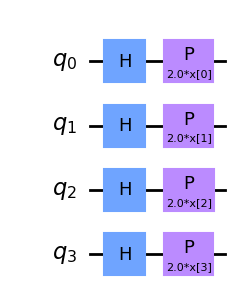

time: 684 ms (started: 2023-04-27 17:02:06 +00:00)


In [ ]:
#prepare VQC circuit input embedding and draw it
#%pip install qiskit[machine-learning]

from qiskit.circuit.library import ZFeatureMap,ZZFeatureMap
num_features = features.shape[1]
feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

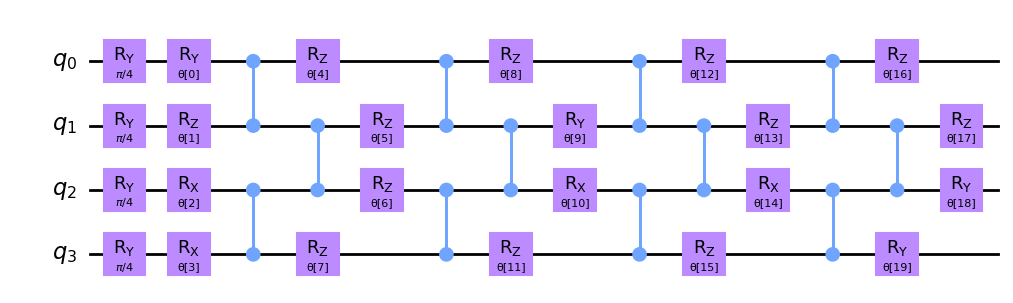

time: 1.74 s (started: 2023-04-27 17:02:07 +00:00)


In [ ]:
#prepare VQC trainable circuit and draw it
from qiskit.circuit.library import RealAmplitudes, PauliTwoDesign
ansatz = PauliTwoDesign(num_qubits=num_features, reps=4)
ansatz.decompose().draw(output="mpl", fold=20)

In [ ]:
# prepare optimizer
from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=100)

time: 730 µs (started: 2023-04-27 17:02:08 +00:00)


In [ ]:
# prepare sampler to measure the circuit multiple times and obtain counts
from qiskit.primitives import Sampler
sampler = Sampler()

time: 622 µs (started: 2023-04-27 17:02:08 +00:00)


In [ ]:
#prepare callback for plotting loss
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

time: 4.86 ms (started: 2023-04-27 17:02:08 +00:00)


In [ ]:
# put all the parts together
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

time: 35.8 ms (started: 2023-04-27 17:02:08 +00:00)


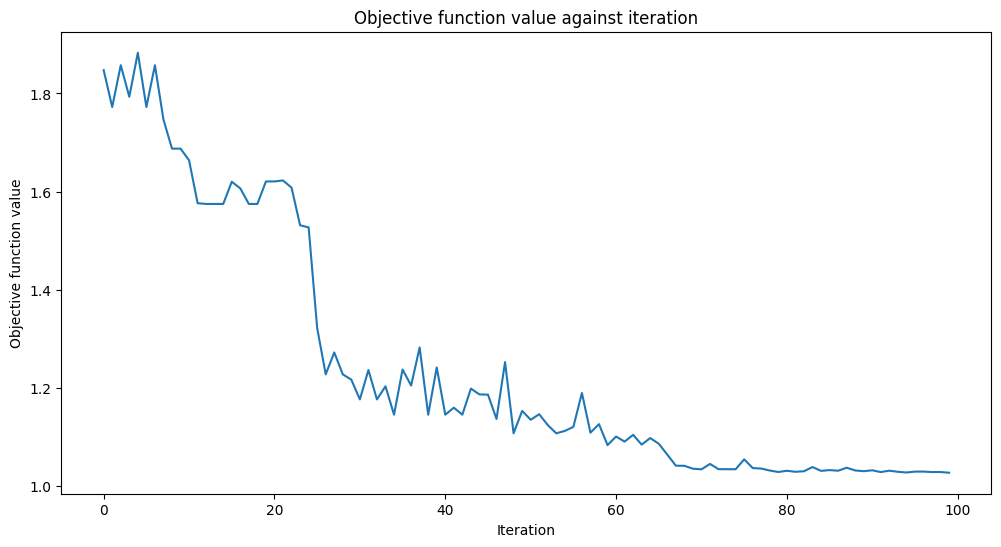

Training time: 151 seconds
time: 2min 30s (started: 2023-04-27 17:02:08 +00:00)


In [ ]:
# run the training process
start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [ ]:
# evalute trained QNN on trining and test sets
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.86
Quantum VQC on the test dataset:     0.83
time: 2.22 s (started: 2023-04-27 17:04:39 +00:00)


In [ ]:
# Data encoding - https://qiskit.org/documentation/apidoc/circuit_library.html
# - PauliFeatureMap
#   - This is a feature map that applies a series of single-qubit Pauli 
#     rotations to the input qubits, followed by a CNOT gate between each pair 
#     of qubits. It can be used to generate features for classification tasks, 
#     where the input data is encoded in the state of the qubits.
# - ZFeatureMap
#   - This is a feature map that applies a series of single-qubit rotations 
#     around the z-axis, followed by a CNOT gate between each pair of qubits. 
#     It can also be used to generate features for classification tasks.
# - ZZFeatureMap
#   - This is a feature map that applies a series of two-qubit ZZ interactions 
#     between pairs of qubits, followed by a CNOT gate between each pair of 
#     qubits. It can be used to generate features for classification tasks, as 
#     well as for unsupervised learning tasks like clustering.
# - StatePreparation
#   - This is a class that can be used to prepare arbitrary quantum states on a 
#     set of qubits. It takes a quantum circuit as input, which can be used to 
#     prepare the desired state by applying a series of gates to the qubits.

# Variational / parameterized circuit (ansatz) - https://qiskit.org/documentation/apidoc/circuit_library.html
# - NLocal
#   - This is a general parameterized quantum circuit that can include any 
#     combination of single-qubit and two-qubit gates. The circuit is defined 
#     by a set of parameters that can be optimized using a classical 
#     optimization algorithm.
# - TwoLocal
#   - This is a parameterized quantum circuit that is designed specifically for 
#     variational algorithms. It consists of layers of entangling gates, 
#     followed by layers of single-qubit gates. The circuit can be customized 
#     by specifying the type of entangling gates and single-qubit gates used, 
#     as well as the number of layers.
# - PauliTwoDesign
#   - This is a parameterized quantum circuit that is designed specifically for 
#     variational algorithms. It consists of layers of two-qubit Pauli 
#     operators, followed by layers of single-qubit Pauli operators. The 
#     circuit can be customized by specifying the number of layers and the 
#     Pauli operators used.
# - RealAmplitudes
#   - This is a parameterized quantum circuit that consists of layers of 
#     single-qubit rotation gates, where the rotation angles are real numbers. 
#     The circuit can be customized by specifying the number of layers and the 
#     type of rotation gates used.
# - EfficientSU2
#   - This is a parameterized quantum circuit that consists of layers of 
#     single-qubit and two-qubit gates, where the single-qubit gates are 
#     parameterized by real numbers and the two-qubit gates are fixed. The 
#     circuit is designed to be efficient in terms of the number of parameters 
#     required for a given number of qubits.

# Depth - Just number of Reps for each
# Reps - (1)  / time  / train / test
# ZFeatureMap(1) + RealAmplitudes(3) = 133s / 0.68  / 0.7
# ZFeatureMap(2) + RealAmplitudes(3) = 149s / 0.9   / 0.97
# ZFeatureMap(1) + RealAmplitudes(6) = 149s / 0.9   / 0.97

time: 325 µs (started: 2023-04-27 17:04:42 +00:00)


time: 8.32 ms (started: 2023-04-27 17:04:42 +00:00)
